In [1]:
import numpy as np
import os, shutil, glob, tempfile, gc
import math, random
from datetime import datetime
import PIL
import PIL.Image
import tensorflow as tf

from tensorflow import keras
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

mos_img_dir = './datasets/ParkDatasets/ParkDatasetAug'
class_names = ['Aedes albopictus', 'Aedes vexans', 'Anopheles sinensis', 'Culex pipiens', 'Culex tritaeniorhynchus', 'Non vectors']

SDO = 0.3

NUM_EPOCH_PER_TRAIN = 40

BATCH_SIZE = 8

# initial value of learning rate
LR = 2e-5
# multiplier factor
LR_MULTIPLIER = 0.5
# number of epochs per reduction
NUM_EPOCH_PER_LR_UPDATE = 10

# original image size
IMG_SIZE = 224

# ratio of (train, val, test)
RATIO = (0.80, 0.2, 0) # train, val, test -> We don't need test = val

# Function to callback every beginning of each epoch
# Learning rate adaptation
def lr_scheduler(epoch, lr):
    return lr * LR_MULTIPLIER if (epoch % NUM_EPOCH_PER_LR_UPDATE) == 0 else lr

lr_adjust = keras.callbacks.LearningRateScheduler(lr_scheduler, verbose=1)
# Early stopping
early_stopping = keras.callbacks.EarlyStopping(monitor='val_accuracy', baseline=0.2,  min_delta = 0.0001, 
                               patience=15, restore_best_weights = True)


2022-09-26 11:10:58.879381: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [2]:
from keras import initializers, Input, layers
# from tensorflow.keras.utils import Sequence
# from keras.callbacks import EarlyStopping
from keras.models import Sequential, Model, load_model
from keras.layers import Dense, Flatten, Conv2D, Concatenate, Dropout, SpatialDropout2D, SpatialDropout1D, MaxPool2D, Add


In [3]:
def buildSDModel():
    # Create Model that is similar to VGG16 with early combination of two images
    input0 = Input(shape=(224, 224, 3), name="img0")
    first_conv = Conv2D(filters=64, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(input0)
    block1_conv2 = Conv2D(filters=64, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(first_conv)

    maxpool_1 = MaxPool2D(pool_size=(2,2),strides=(2,2))(block1_conv2)
    spa_1 = SpatialDropout2D(SDO)(maxpool_1)
    block2_conv1 = Conv2D(filters=128, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(spa_1)
    block2_conv2 = Conv2D(filters=128, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(block2_conv1)
    maxpool_2 = MaxPool2D(pool_size=(2,2),strides=(2,2))(block2_conv2)
    spa_2 = SpatialDropout2D(SDO)(maxpool_2)
    block3_conv1 = Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(spa_2)
    block3_conv2 = Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(block3_conv1)
    block3_conv3 = Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(block3_conv2)
    maxpool_3 = MaxPool2D(pool_size=(2,2),strides=(2,2))(block3_conv3)
    spa_3 = SpatialDropout2D(SDO)(maxpool_3)
    block4_conv1 = Conv2D(filters=512, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(spa_3)
    block4_conv2 = Conv2D(filters=512, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(block4_conv1)
    block4_conv3 = Conv2D(filters=512, kernel_size=(3,3) ,strides=(1,1), padding='same', activation='relu')(block4_conv2)
    maxpool_4 = MaxPool2D(pool_size=(2,2),strides=(2,2))(block4_conv3)
    spa_4 = SpatialDropout2D(SDO)(maxpool_4)
    block5_conv1 = Conv2D(filters=512, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(spa_4)
    block5_conv2 = Conv2D(filters=512, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(block5_conv1)
    block5_conv3 = Conv2D(filters=512, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(block5_conv2)
    maxpool_5 = MaxPool2D(pool_size=(2,2),strides=(2,2))(block5_conv3)
    spa_5 = SpatialDropout2D(SDO)(maxpool_5)
    flat = Flatten()(spa_5)
    dense1 = Dense(4096, activation='relu')(flat)
    drop_1 = Dropout(0)(dense1)
    dense2 = Dense(4096, activation='relu')(drop_1)
    drop_2 = Dropout(0)(dense2)
    output = Dense(6, activation='softmax')(drop_2)
    model = Model(inputs=input0, outputs=output)
    return model

In [4]:
def loadVGG16ImageNetWeightsSD(model):
    # load VGG16 with imagenet weights
    from keras.applications.vgg16 import VGG16
    vgg = VGG16(include_top=True, weights ='imagenet',  input_shape=(224, 224, 3))

    # print VGG16's layer names to copy its parameters
    [layer.name for layer in vgg.layers]

    # Check our modified VGG16
    [layer.name for layer in model.layers]

    # Apply weight from VGG16 to our Modified version
    for layer in vgg.layers: 
        if layer.name == 'block1_conv1':
            model.layers[1].set_weights(layer.get_weights()),
        elif layer.name == 'block1_conv2': 
            model.layers[2].set_weights(layer.get_weights()),
        elif layer.name == 'block2_conv1': 
            model.layers[5].set_weights(layer.get_weights()) 
        elif layer.name == 'block2_conv2': 
            model.layers[6].set_weights(layer.get_weights())
        elif layer.name == 'block3_conv1':
            model.layers[9].set_weights(layer.get_weights())
        elif layer.name == 'block3_conv2':
            model.layers[10].set_weights(layer.get_weights())
        elif layer.name == 'block3_conv3':
            model.layers[11].set_weights(layer.get_weights())
        elif layer.name == 'block4_conv1':
            model.layers[14].set_weights(layer.get_weights())
        elif layer.name == 'block4_conv2':
            model.layers[15].set_weights(layer.get_weights())
        elif layer.name == 'block4_conv3':
            model.layers[16].set_weights(layer.get_weights())
        elif layer.name == 'block5_conv1':
            model.layers[19].set_weights(layer.get_weights())
        elif layer.name == 'block5_conv2':
            model.layers[20].set_weights(layer.get_weights())
        elif layer.name == 'block5_conv3':
            model.layers[21].set_weights(layer.get_weights())
        elif layer.name == 'fc1':
            model.layers[25].set_weights(layer.get_weights())
        elif layer.name == 'fc2':
            model.layers[27].set_weights(layer.get_weights())
    return model


In [5]:
def between0i1x(f):
    if 0 <= f < 1:
        return True
    else:
        return False
    

In [6]:
def RandomTrainValTest(src_dir, dst_dir, ratio = (0.8, 0.2, 0)):
    #check if Destination directory already exists
    if os.path.exists(dst_dir):
        print('Destination directory already exists. Do nothing!!!')
        return
    TRAIN_RATIO = round(ratio[0], 3)
    VAL_RATIO = round(ratio[1], 3)
    TEST_RATIO = round(1 - TRAIN_RATIO - VAL_RATIO, 3)
    if not between0i1x(TEST_RATIO) or not between0i1x(VAL_RATIO) or not between0i1x(TRAIN_RATIO):
        print('Ratio must be more than or equal 0 and less than 1.')
        return
    print('Ratio = (' + str(TRAIN_RATIO) +', ' + str(VAL_RATIO) + ', ' + str(TEST_RATIO) + ').' )
    if TEST_RATIO != round(ratio[2],3):
        print('Sum of ratio must be 1.')
        return
    
    # create a temp dir and copy all files recursively to temp_dir
    tmp = tempfile.TemporaryDirectory()
    tmp_dir = tmp.name + '/tmp/'
    shutil.copytree(src_dir, tmp_dir)
    # scan species, they must be immediatly under the src_dir 
    for species in os.scandir(src_dir):
        if not species.name.startswith('.') and species.is_dir():
            class_dir = tmp_dir + '/' + species.name
            print('Found ' + species.name)
            #calculate No. of files in each species 
            file_no = 0
            for entry2 in os.scandir(class_dir):
                if not entry2.name.startswith('.') and entry2.is_file():
                    file_no += 1
            print('No. of files in ' + species.name + ' = ' + str(file_no) + '.')
            # create subdirectories if necessary
            if not os.path.exists(dst_dir):
                os.mkdir(dst_dir)
            test_dir = dst_dir + '/test/' 
            val_dir = dst_dir + '/val/' 
            train_dir = dst_dir + '/train/' 
            if not os.path.exists(test_dir):
                os.mkdir(test_dir)
            if not os.path.exists(val_dir):
                os.mkdir(val_dir)
            if not os.path.exists(train_dir):
                os.mkdir(train_dir)
            # create species.name dir    
            stest_dir = test_dir + species.name + '/'
            sval_dir = val_dir + species.name + '/'
            strain_dir = train_dir + species.name + '/'
            if not os.path.exists(stest_dir):
                os.mkdir(stest_dir)
            if not os.path.exists(sval_dir):
                os.mkdir(sval_dir)
            if not os.path.exists(strain_dir):
                os.mkdir(strain_dir)
            # calculate number of files for train, val, test    
            no_file_train = math.ceil(file_no*TRAIN_RATIO)
            no_file_val = math.ceil(file_no*VAL_RATIO)
            no_file_test = math.ceil(file_no*TEST_RATIO)
            
            # for training data
            file_no = 0
            while file_no < no_file_train : 
                selectedFile = random.choice(os.listdir(tmp_dir + '/' + species.name))
                # find index no
                no = selectedFile.rfind('_') 
                # select all files that have the same index no.
                SelectedFiles = '*' + selectedFile[no:] 
                # move all the selected files
                file_moved = 0
                for file in glob.iglob(class_dir +'/'+ SelectedFiles, recursive=True):    
                    file_name = os.path.basename(file)
                    shutil.move(file, strain_dir + file_name)
                    file_moved += 1
                # sum file_moved to file_no    
                file_no += file_moved
            print('No. of files in "' + strain_dir + '" should be around ' + str(no_file_train) + '.')
            print('No. of files in ' +strain_dir + ' = ' + str(file_no) +'.' )
            
            # for test data
            file_no = 0
            while file_no < no_file_test and os.listdir(tmp_dir + '/' + species.name): 
                selectedFile = random.choice(os.listdir(tmp_dir + '/' + species.name))
                # find index no
                no = selectedFile.rfind('_') 
                # select all files that have the same index no.
                SelectedFiles = '*' + selectedFile[no:] 
                # move all the selected files
                file_moved = 0
                for file in glob.iglob(class_dir +'/'+ SelectedFiles, recursive=True):    
                    file_name = os.path.basename(file)
                    shutil.move(file, strain_dir + file_name)
                    file_moved += 1
                # sum file_moved to file_no    
                file_no += file_moved
            print('No. of files in "' + stest_dir + '" should be around ' + str(no_file_test) + '.')
            print('No. of files in ' +stest_dir + ' = ' + str(file_no) +'.' )
            #move all remaining files to val_dir
            SelectedFiles = '*'
            file_moved = 0
            for file in glob.iglob(class_dir +'/'+ SelectedFiles, recursive=True):    
                file_name = os.path.basename(file)
                shutil.move(file, sval_dir + file_name)
                file_moved += 1
            file_no = file_moved    
            print('No. of files in "' + sval_dir + '" should be around ' + str(no_file_val) + '.')
            print('No. of files in ' +sval_dir + ' = ' + str(file_no) +'.' )

In [7]:
def read_ds(src_dir):
    
    train_dir = src_dir  + '/train'
    val_dir = src_dir    + '/val'
    
    train_ds = tf.keras.utils.image_dataset_from_directory(
      train_dir,
      #validation_split=0.2,
      #subset="training",
      seed=123,
      image_size=(IMG_SIZE, IMG_SIZE),
      shuffle = False,
      label_mode='categorical',
      batch_size=BATCH_SIZE)

    val_ds = tf.keras.utils.image_dataset_from_directory(
      val_dir,
      #validation_split=0.2,
      #subset="validation",
      seed=123,
      shuffle = False,
      label_mode='categorical',
      image_size=(IMG_SIZE, IMG_SIZE),
      batch_size=BATCH_SIZE)



    return (train_ds, val_ds)



In [8]:
def preprocessDS(train_ds, val_ds):
    train_num_batch = sum(1 for _ in train_ds)
    val_num_batch = sum(1 for _ in val_ds)

    # Normalize to (0-1)
    normalization_layer = tf.keras.layers.Rescaling(1./255)
    train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
    val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))




    # Load the dataset onto GPU RAM for superspeed
    train_ds = train_ds.cache()
    val_ds = val_ds.cache()

    # reshuffle the train ds every batch (second times onwords in GPU), but shuffle val ds only once
    train_ds = train_ds.shuffle(train_num_batch, reshuffle_each_iteration=True)
    val_ds   = val_ds.shuffle(val_num_batch, reshuffle_each_iteration=False)


    # prefetch the datasets for lower latency
    train_ds = train_ds.prefetch(tf.data.AUTOTUNE)
    val_ds = val_ds.prefetch(tf.data.AUTOTUNE)

    return (train_ds, val_ds)
    #...

In [9]:
def compileModel(model):
    # Optimizer hyperparameter
    myAdam = keras.optimizers.Adam(
        learning_rate=LR/LR_MULTIPLIER,
        beta_1=0.9,
        beta_2=0.999,
        epsilon=0.0001,
        amsgrad=True,
        name="Adam",)

    model.compile(optimizer=myAdam,
              loss=tf.keras.losses.CategoricalCrossentropy(
                    from_logits=False,
                    label_smoothing=0.0,
                    axis=-1,
                    reduction="auto",
                    name="categorical_crossentropy"),
              metrics=['accuracy'])
    return model


In [10]:
def fitModel(model, train_ds, val_ds, lr_adjust = None, early_stopping = None):
    print('Start fitting from ' + datetime.now().strftime("%Y/%m/%d-%H:%M:%S"))
    history = model.fit(train_ds,    
                  epochs=NUM_EPOCH_PER_TRAIN,   
                  validation_data = val_ds,
                  callbacks=[lr_adjust, early_stopping])
    print('End fitting at '+ datetime.now().strftime("%Y/%m/%d-%H:%M:%S"))
    return history

In [11]:
def plotAccuracyLoss(hist):
    acc = hist.history['accuracy']
    val_acc = hist.history['val_accuracy']

    loss = hist.history['loss']
    val_loss = hist.history['val_loss']

    #epochs_range = range(epochs)
    epochs_range = range(len(loss))
    plt.figure(figsize=(8, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

In [12]:
def printConfusionMatrix(model, ds):
    #Confution Matrix and Classification Report

    Y_pred = model.predict(ds)
    y_pred = np.argmax(Y_pred, axis=1)
    Y_true = np.concatenate([y for x, y in ds], axis=0)
    y_true = np.argmax(Y_true, axis=1)
    print('Confusion Matrix')
    print(confusion_matrix(y_true, y_pred))
    print('')
    print('')
    print('Classification Report')

    print(classification_report(y_true, y_pred, target_names=class_names))


In [13]:
def saveSDOModel(model):
    path = './models/Model_SDO_Park_' + datetime.now().strftime("%Y-%m-%d_%H-%M") +'.h5'
    print('Model is saved in ' + path)
    model.save(path)
    return path

In [14]:
tmpX = tempfile.TemporaryDirectory().name
RandomTrainValTest(mos_img_dir, tmpX, ratio = (0.8,0.2,0))

Ratio = (0.8, 0.2, -0.0).
Found Aedes vexans
No. of files in Aedes vexans = 5901.
No. of files in "/tmp/tmpfmgw8cj1/train/Aedes vexans/" should be around 4721.
No. of files in /tmp/tmpfmgw8cj1/train/Aedes vexans/ = 4727.
No. of files in "/tmp/tmpfmgw8cj1/test/Aedes vexans/" should be around 0.
No. of files in /tmp/tmpfmgw8cj1/test/Aedes vexans/ = 0.
No. of files in "/tmp/tmpfmgw8cj1/val/Aedes vexans/" should be around 1181.
No. of files in /tmp/tmpfmgw8cj1/val/Aedes vexans/ = 1174.
Found Anopheles sinensis
No. of files in Anopheles sinensis = 5923.
No. of files in "/tmp/tmpfmgw8cj1/train/Anopheles sinensis/" should be around 4739.
No. of files in /tmp/tmpfmgw8cj1/train/Anopheles sinensis/ = 4743.
No. of files in "/tmp/tmpfmgw8cj1/test/Anopheles sinensis/" should be around 0.
No. of files in /tmp/tmpfmgw8cj1/test/Anopheles sinensis/ = 0.
No. of files in "/tmp/tmpfmgw8cj1/val/Anopheles sinensis/" should be around 1185.
No. of files in /tmp/tmpfmgw8cj1/val/Anopheles sinensis/ = 1180.
Foun

In [15]:
(train_ds, val_ds) = read_ds(tmpX)
(train_ds, val_ds) = preprocessDS(train_ds, val_ds)

Found 28634 files belonging to 6 classes.


2022-09-26 11:11:13.689423: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-09-26 11:11:14.465857: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22227 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:af:00.0, compute capability: 8.6


Found 7106 files belonging to 6 classes.


In [16]:
model = buildSDModel()
model.summary()
model = loadVGG16ImageNetWeightsSD(model)
model = compileModel(model)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 img0 (InputLayer)           [(None, 224, 224, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 224, 224, 64)      1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 224, 224, 64)      36928     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 64)     0         
 )                                                               
                                                                 
 spatial_dropout2d (SpatialD  (None, 112, 112, 64)     0         
 ropout2D)                                                       
                                                                 
 conv2d_2 (Conv2D)           (None, 112, 112, 128)     73856 

In [17]:
fitHistory = fitModel(model, train_ds, val_ds, lr_adjust, early_stopping)
maxAcc = np.max(fitHistory.history['val_accuracy'])

Start fitting from 2022/09/26-11:11:22

Epoch 1: LearningRateScheduler setting learning rate to 1.9999999494757503e-05.
Epoch 1/40


2022-09-26 11:11:29.035279: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8401
2022-09-26 11:11:31.305842: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


3580/3580 [==============================] - 239s 64ms/step - loss: 1.6407 - accuracy: 0.2926 - val_loss: 1.2196 - val_accuracy: 0.4683 - lr: 2.0000e-05

Epoch 2: LearningRateScheduler setting learning rate to 1.9999999494757503e-05.
Epoch 2/40
3580/3580 [==============================] - 221s 62ms/step - loss: 0.8605 - accuracy: 0.6645 - val_loss: 0.5153 - val_accuracy: 0.7934 - lr: 2.0000e-05

Epoch 3: LearningRateScheduler setting learning rate to 1.9999999494757503e-05.
Epoch 3/40
3580/3580 [==============================] - 219s 61ms/step - loss: 0.3973 - accuracy: 0.8539 - val_loss: 0.2724 - val_accuracy: 0.8950 - lr: 2.0000e-05

Epoch 4: LearningRateScheduler setting learning rate to 1.9999999494757503e-05.
Epoch 4/40
3580/3580 [==============================] - 221s 62ms/step - loss: 0.2198 - accuracy: 0.9208 - val_loss: 0.1943 - val_accuracy: 0.9339 - lr: 2.0000e-05

Epoch 5: LearningRateScheduler setting learning rate to 1.9999999494757503e-05.
Epoch 5/40
3580/3580 [=========

3580/3580 [==============================] - 211s 59ms/step - loss: 0.0028 - accuracy: 0.9988 - val_loss: 0.0779 - val_accuracy: 0.9818 - lr: 2.5000e-06

Epoch 35: LearningRateScheduler setting learning rate to 2.499999936844688e-06.
Epoch 35/40
3580/3580 [==============================] - 213s 60ms/step - loss: 0.0022 - accuracy: 0.9991 - val_loss: 0.0782 - val_accuracy: 0.9820 - lr: 2.5000e-06

Epoch 36: LearningRateScheduler setting learning rate to 2.499999936844688e-06.
Epoch 36/40
3580/3580 [==============================] - 207s 58ms/step - loss: 0.0027 - accuracy: 0.9992 - val_loss: 0.0802 - val_accuracy: 0.9811 - lr: 2.5000e-06

Epoch 37: LearningRateScheduler setting learning rate to 2.499999936844688e-06.
Epoch 37/40
3580/3580 [==============================] - 207s 58ms/step - loss: 0.0018 - accuracy: 0.9996 - val_loss: 0.0839 - val_accuracy: 0.9799 - lr: 2.5000e-06

Epoch 38: LearningRateScheduler setting learning rate to 2.499999936844688e-06.
Epoch 38/40
3580/3580 [=====

Maximum test accuracy is at 98.28 %.


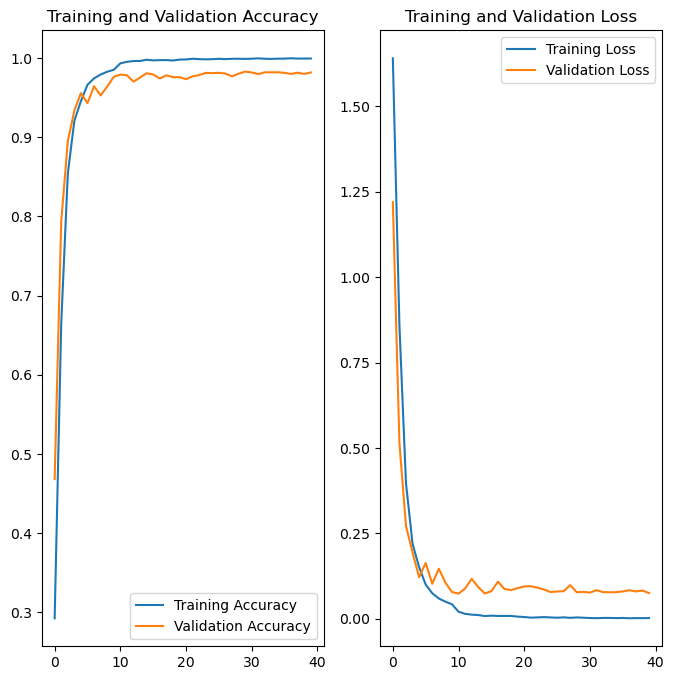

In [18]:
print('Maximum test accuracy is at', np.round(maxAcc*100,2), '%.')
plotAccuracyLoss(fitHistory)

In [19]:
printConfusionMatrix(model, val_ds)
earlyModelPath = saveSDOModel(model)

889/889 [==============================] - 13s 15ms/step
Confusion Matrix
[[1162    1    1    2    0   26]
 [   0 1150    0    0   23    1]
 [   2    4 1173    0    0    1]
 [   1    0    0 1182    0    1]
 [   1   26    0    0 1151    0]
 [   4   21    0   15    0 1158]]


Classification Report
                         precision    recall  f1-score   support

       Aedes albopictus       0.99      0.97      0.98      1192
           Aedes vexans       0.96      0.98      0.97      1174
     Anopheles sinensis       1.00      0.99      1.00      1180
          Culex pipiens       0.99      1.00      0.99      1184
Culex tritaeniorhynchus       0.98      0.98      0.98      1178
            Non vectors       0.98      0.97      0.97      1198

               accuracy                           0.98      7106
              macro avg       0.98      0.98      0.98      7106
           weighted avg       0.98      0.98      0.98      7106

Model is saved in ./models/Model_SDO_Park_2022-09-

In [20]:
#-----Run 2

In [21]:
tmpX = tempfile.TemporaryDirectory().name
RandomTrainValTest(mos_img_dir, tmpX, ratio = (0.8,0.2,0))
#-----------------------

Ratio = (0.8, 0.2, -0.0).
Found Aedes vexans
No. of files in Aedes vexans = 5901.
No. of files in "/tmp/tmpz553tqn2/train/Aedes vexans/" should be around 4721.
No. of files in /tmp/tmpz553tqn2/train/Aedes vexans/ = 4741.
No. of files in "/tmp/tmpz553tqn2/test/Aedes vexans/" should be around 0.
No. of files in /tmp/tmpz553tqn2/test/Aedes vexans/ = 0.
No. of files in "/tmp/tmpz553tqn2/val/Aedes vexans/" should be around 1181.
No. of files in /tmp/tmpz553tqn2/val/Aedes vexans/ = 1160.
Found Anopheles sinensis
No. of files in Anopheles sinensis = 5923.
No. of files in "/tmp/tmpz553tqn2/train/Anopheles sinensis/" should be around 4739.
No. of files in /tmp/tmpz553tqn2/train/Anopheles sinensis/ = 4746.
No. of files in "/tmp/tmpz553tqn2/test/Anopheles sinensis/" should be around 0.
No. of files in /tmp/tmpz553tqn2/test/Anopheles sinensis/ = 0.
No. of files in "/tmp/tmpz553tqn2/val/Anopheles sinensis/" should be around 1185.
No. of files in /tmp/tmpz553tqn2/val/Anopheles sinensis/ = 1177.
Foun

In [22]:
(train_ds, val_ds) = read_ds(tmpX)
(train_ds, val_ds) = preprocessDS(train_ds, val_ds)
#-----------------------

Found 28687 files belonging to 6 classes.
Found 7053 files belonging to 6 classes.


In [23]:
model = buildSDModel()
model = loadVGG16ImageNetWeightsSD(model)
model = compileModel(model)
fitHistory = fitModel(model, train_ds, val_ds, lr_adjust, early_stopping)
#-----------------------

Start fitting from 2022/09/26-13:32:34

Epoch 1: LearningRateScheduler setting learning rate to 1.9999999494757503e-05.
Epoch 1/40
3586/3586 [==============================] - 216s 58ms/step - loss: 1.5106 - accuracy: 0.3592 - val_loss: 0.9871 - val_accuracy: 0.6207 - lr: 2.0000e-05

Epoch 2: LearningRateScheduler setting learning rate to 1.9999999494757503e-05.
Epoch 2/40
3586/3586 [==============================] - 211s 59ms/step - loss: 0.7474 - accuracy: 0.7126 - val_loss: 0.4980 - val_accuracy: 0.7977 - lr: 2.0000e-05

Epoch 3: LearningRateScheduler setting learning rate to 1.9999999494757503e-05.
Epoch 3/40
3586/3586 [==============================] - 208s 58ms/step - loss: 0.3485 - accuracy: 0.8740 - val_loss: 0.3907 - val_accuracy: 0.8568 - lr: 2.0000e-05

Epoch 4: LearningRateScheduler setting learning rate to 1.9999999494757503e-05.
Epoch 4/40
3586/3586 [==============================] - 217s 60ms/step - loss: 0.2040 - accuracy: 0.9280 - val_loss: 0.2005 - val_accuracy: 0.931

Epoch 34/40
3586/3586 [==============================] - 206s 57ms/step - loss: 0.0026 - accuracy: 0.9992 - val_loss: 0.0807 - val_accuracy: 0.9803 - lr: 2.5000e-06

Epoch 35: LearningRateScheduler setting learning rate to 2.499999936844688e-06.
Epoch 35/40
3586/3586 [==============================] - 207s 58ms/step - loss: 0.0024 - accuracy: 0.9994 - val_loss: 0.0858 - val_accuracy: 0.9793 - lr: 2.5000e-06

Epoch 36: LearningRateScheduler setting learning rate to 2.499999936844688e-06.
Epoch 36/40
3586/3586 [==============================] - 202s 56ms/step - loss: 0.0029 - accuracy: 0.9991 - val_loss: 0.0781 - val_accuracy: 0.9810 - lr: 2.5000e-06

Epoch 37: LearningRateScheduler setting learning rate to 2.499999936844688e-06.
Epoch 37/40
3586/3586 [==============================] - 210s 59ms/step - loss: 0.0025 - accuracy: 0.9992 - val_loss: 0.0884 - val_accuracy: 0.9779 - lr: 2.5000e-06

Epoch 38: LearningRateScheduler setting learning rate to 2.499999936844688e-06.
Epoch 38/40
3586

Maximum test accuracy is at 98.17 %.


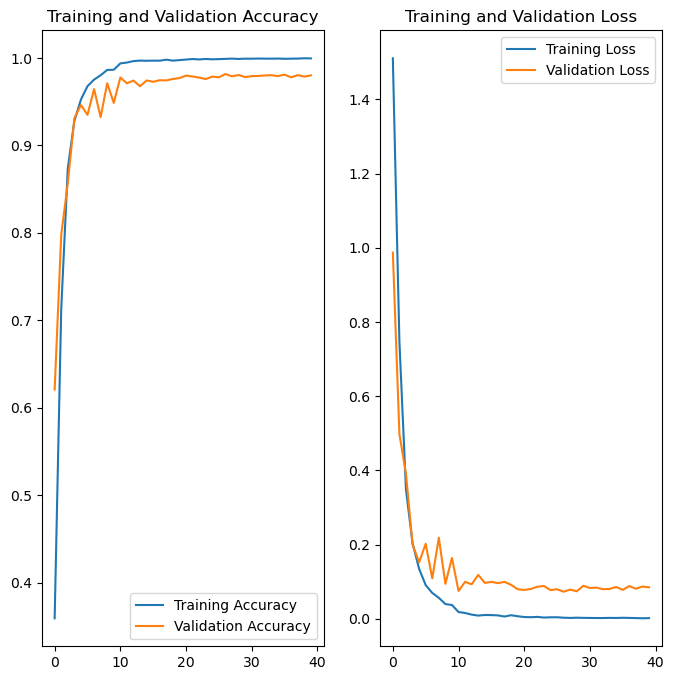

In [24]:
maxAcc = np.max(fitHistory.history['val_accuracy'])
print('Maximum test accuracy is at', np.round(maxAcc*100,2), '%.')
plotAccuracyLoss(fitHistory)
#-----------------------

In [25]:
printConfusionMatrix(model, val_ds)
earlyModelPath = saveSDOModel(model)

882/882 [==============================] - 13s 15ms/step
Confusion Matrix
[[1143    5    0    3    3   12]
 [   0 1143    3    0   12    2]
 [   0    5 1143    0    6   23]
 [   0    5    0 1180    2    1]
 [   1   10    0    0 1170    0]
 [   3   24    0   13    7 1134]]


Classification Report
                         precision    recall  f1-score   support

       Aedes albopictus       1.00      0.98      0.99      1166
           Aedes vexans       0.96      0.99      0.97      1160
     Anopheles sinensis       1.00      0.97      0.98      1177
          Culex pipiens       0.99      0.99      0.99      1188
Culex tritaeniorhynchus       0.97      0.99      0.98      1181
            Non vectors       0.97      0.96      0.96      1181

               accuracy                           0.98      7053
              macro avg       0.98      0.98      0.98      7053
           weighted avg       0.98      0.98      0.98      7053

Model is saved in ./models/Model_SDO_Park_2022-09-

In [26]:
#-----Run 3

In [27]:
tmpX = tempfile.TemporaryDirectory().name
RandomTrainValTest(mos_img_dir, tmpX, ratio = (0.8,0.2,0))
#-----------------------

Ratio = (0.8, 0.2, -0.0).
Found Aedes vexans
No. of files in Aedes vexans = 5901.
No. of files in "/tmp/tmpuc39h9ya/train/Aedes vexans/" should be around 4721.
No. of files in /tmp/tmpuc39h9ya/train/Aedes vexans/ = 4721.
No. of files in "/tmp/tmpuc39h9ya/test/Aedes vexans/" should be around 0.
No. of files in /tmp/tmpuc39h9ya/test/Aedes vexans/ = 0.
No. of files in "/tmp/tmpuc39h9ya/val/Aedes vexans/" should be around 1181.
No. of files in /tmp/tmpuc39h9ya/val/Aedes vexans/ = 1180.
Found Anopheles sinensis
No. of files in Anopheles sinensis = 5923.
No. of files in "/tmp/tmpuc39h9ya/train/Anopheles sinensis/" should be around 4739.
No. of files in /tmp/tmpuc39h9ya/train/Anopheles sinensis/ = 4746.
No. of files in "/tmp/tmpuc39h9ya/test/Anopheles sinensis/" should be around 0.
No. of files in /tmp/tmpuc39h9ya/test/Anopheles sinensis/ = 0.
No. of files in "/tmp/tmpuc39h9ya/val/Anopheles sinensis/" should be around 1185.
No. of files in /tmp/tmpuc39h9ya/val/Anopheles sinensis/ = 1177.
Foun

In [28]:
(train_ds, val_ds) = read_ds(tmpX)
(train_ds, val_ds) = preprocessDS(train_ds, val_ds)
#-----------------------

Found 28619 files belonging to 6 classes.
Found 7121 files belonging to 6 classes.


In [29]:
model = buildSDModel()
model = loadVGG16ImageNetWeightsSD(model)
model = compileModel(model)
fitHistory = fitModel(model, train_ds, val_ds, lr_adjust, early_stopping)
#-----------------------

Start fitting from 2022/09/26-15:53:57

Epoch 1: LearningRateScheduler setting learning rate to 1.9999999494757503e-05.
Epoch 1/40
3578/3578 [==============================] - 210s 57ms/step - loss: 1.6178 - accuracy: 0.3063 - val_loss: 1.0763 - val_accuracy: 0.5430 - lr: 2.0000e-05

Epoch 2: LearningRateScheduler setting learning rate to 1.9999999494757503e-05.
Epoch 2/40
3578/3578 [==============================] - 205s 57ms/step - loss: 0.9124 - accuracy: 0.6461 - val_loss: 0.5678 - val_accuracy: 0.7931 - lr: 2.0000e-05

Epoch 3: LearningRateScheduler setting learning rate to 1.9999999494757503e-05.
Epoch 3/40
3578/3578 [==============================] - 205s 57ms/step - loss: 0.4781 - accuracy: 0.8236 - val_loss: 0.2924 - val_accuracy: 0.8851 - lr: 2.0000e-05

Epoch 4: LearningRateScheduler setting learning rate to 1.9999999494757503e-05.
Epoch 4/40
3578/3578 [==============================] - 199s 56ms/step - loss: 0.2676 - accuracy: 0.9031 - val_loss: 0.2461 - val_accuracy: 0.905

Epoch 34/40
3578/3578 [==============================] - 206s 58ms/step - loss: 0.0027 - accuracy: 0.9992 - val_loss: 0.0674 - val_accuracy: 0.9839 - lr: 2.5000e-06
End fitting at 2022/09/26-17:49:57


Maximum test accuracy is at 98.5 %.


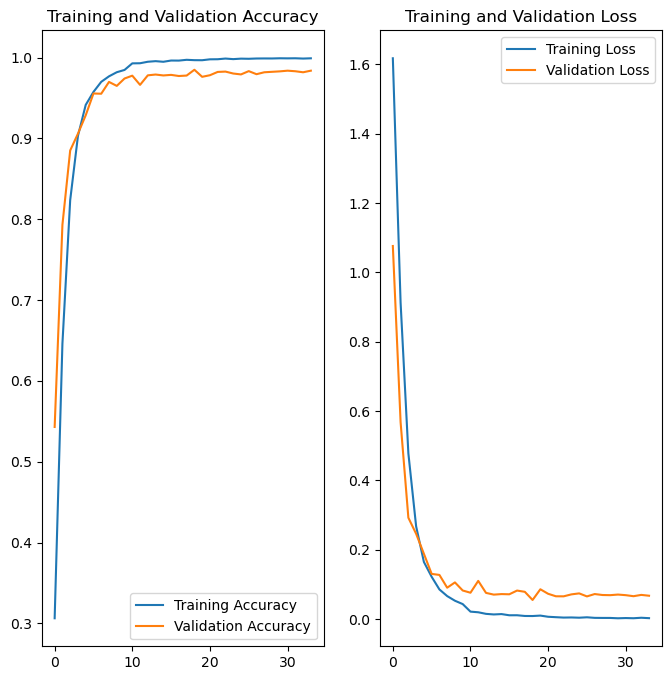

In [30]:
maxAcc = np.max(fitHistory.history['val_accuracy'])
print('Maximum test accuracy is at', np.round(maxAcc*100,2), '%.')
plotAccuracyLoss(fitHistory)
#-----------------------

In [31]:
printConfusionMatrix(model, val_ds)
earlyModelPath = saveSDOModel(model)

891/891 [==============================] - 13s 15ms/step
Confusion Matrix
[[1190    0    0    2    0    4]
 [   0 1147    3    5   11   14]
 [   1    4 1163    2    1    6]
 [   5    0    0 1176    1    8]
 [   0    7    1    0 1172    0]
 [   8   14    4    2    4 1166]]


Classification Report
                         precision    recall  f1-score   support

       Aedes albopictus       0.99      0.99      0.99      1196
           Aedes vexans       0.98      0.97      0.98      1180
     Anopheles sinensis       0.99      0.99      0.99      1177
          Culex pipiens       0.99      0.99      0.99      1190
Culex tritaeniorhynchus       0.99      0.99      0.99      1180
            Non vectors       0.97      0.97      0.97      1198

               accuracy                           0.98      7121
              macro avg       0.98      0.98      0.98      7121
           weighted avg       0.98      0.98      0.98      7121

Model is saved in ./models/Model_SDO_Park_2022-09-

In [32]:
#-----Run 4

In [33]:
tmpX = tempfile.TemporaryDirectory().name
RandomTrainValTest(mos_img_dir, tmpX, ratio = (0.8,0.2,0))
#-----------------------

Ratio = (0.8, 0.2, -0.0).
Found Aedes vexans
No. of files in Aedes vexans = 5901.
No. of files in "/tmp/tmp676639uc/train/Aedes vexans/" should be around 4721.
No. of files in /tmp/tmp676639uc/train/Aedes vexans/ = 4742.
No. of files in "/tmp/tmp676639uc/test/Aedes vexans/" should be around 0.
No. of files in /tmp/tmp676639uc/test/Aedes vexans/ = 0.
No. of files in "/tmp/tmp676639uc/val/Aedes vexans/" should be around 1181.
No. of files in /tmp/tmp676639uc/val/Aedes vexans/ = 1159.
Found Anopheles sinensis
No. of files in Anopheles sinensis = 5923.
No. of files in "/tmp/tmp676639uc/train/Anopheles sinensis/" should be around 4739.
No. of files in /tmp/tmp676639uc/train/Anopheles sinensis/ = 4749.
No. of files in "/tmp/tmp676639uc/test/Anopheles sinensis/" should be around 0.
No. of files in /tmp/tmp676639uc/test/Anopheles sinensis/ = 0.
No. of files in "/tmp/tmp676639uc/val/Anopheles sinensis/" should be around 1185.
No. of files in /tmp/tmp676639uc/val/Anopheles sinensis/ = 1174.
Foun

In [34]:
(train_ds, val_ds) = read_ds(tmpX)
(train_ds, val_ds) = preprocessDS(train_ds, val_ds)
#-----------------------

Found 28696 files belonging to 6 classes.
Found 7044 files belonging to 6 classes.


In [35]:
model = buildSDModel()
model = loadVGG16ImageNetWeightsSD(model)
model = compileModel(model)
fitHistory = fitModel(model, train_ds, val_ds, lr_adjust, early_stopping)
#-----------------------

Start fitting from 2022/09/26-17:50:33

Epoch 1: LearningRateScheduler setting learning rate to 1.9999999494757503e-05.
Epoch 1/40
3587/3587 [==============================] - 216s 58ms/step - loss: 1.6622 - accuracy: 0.2750 - val_loss: 1.2739 - val_accuracy: 0.4712 - lr: 2.0000e-05

Epoch 2: LearningRateScheduler setting learning rate to 1.9999999494757503e-05.
Epoch 2/40
3587/3587 [==============================] - 215s 60ms/step - loss: 1.0132 - accuracy: 0.5982 - val_loss: 0.6920 - val_accuracy: 0.7375 - lr: 2.0000e-05

Epoch 3: LearningRateScheduler setting learning rate to 1.9999999494757503e-05.
Epoch 3/40
3587/3587 [==============================] - 210s 58ms/step - loss: 0.5232 - accuracy: 0.8041 - val_loss: 0.3291 - val_accuracy: 0.8793 - lr: 2.0000e-05

Epoch 4: LearningRateScheduler setting learning rate to 1.9999999494757503e-05.
Epoch 4/40
3587/3587 [==============================] - 210s 59ms/step - loss: 0.2842 - accuracy: 0.8965 - val_loss: 0.2191 - val_accuracy: 0.919

Epoch 34/40
3587/3587 [==============================] - 202s 56ms/step - loss: 0.0035 - accuracy: 0.9989 - val_loss: 0.0714 - val_accuracy: 0.9794 - lr: 2.5000e-06

Epoch 35: LearningRateScheduler setting learning rate to 2.499999936844688e-06.
Epoch 35/40
3587/3587 [==============================] - 201s 56ms/step - loss: 0.0025 - accuracy: 0.9994 - val_loss: 0.0749 - val_accuracy: 0.9791 - lr: 2.5000e-06

Epoch 36: LearningRateScheduler setting learning rate to 2.499999936844688e-06.
Epoch 36/40
3587/3587 [==============================] - 206s 57ms/step - loss: 0.0031 - accuracy: 0.9991 - val_loss: 0.0733 - val_accuracy: 0.9791 - lr: 2.5000e-06

Epoch 37: LearningRateScheduler setting learning rate to 2.499999936844688e-06.
Epoch 37/40
3587/3587 [==============================] - 201s 56ms/step - loss: 0.0038 - accuracy: 0.9988 - val_loss: 0.0692 - val_accuracy: 0.9807 - lr: 2.5000e-06

Epoch 38: LearningRateScheduler setting learning rate to 2.499999936844688e-06.
Epoch 38/40
3587

Maximum test accuracy is at 98.15 %.


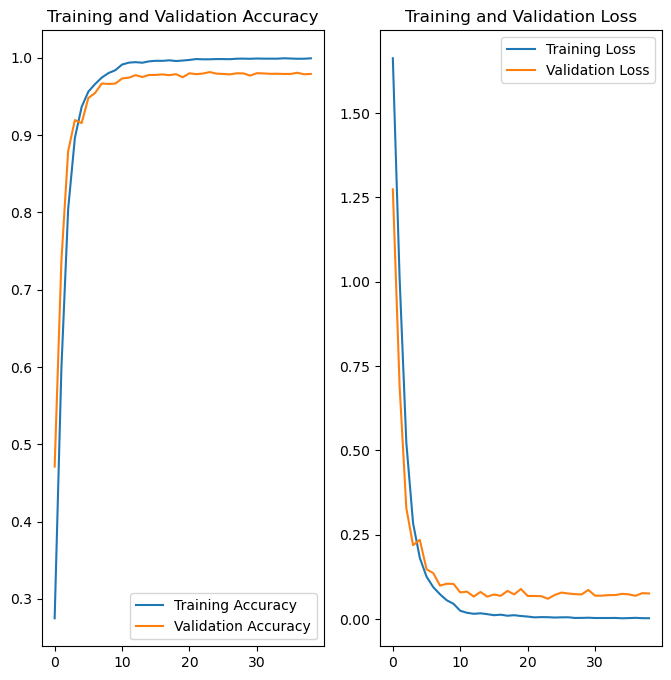

In [36]:
maxAcc = np.max(fitHistory.history['val_accuracy'])
print('Maximum test accuracy is at', np.round(maxAcc*100,2), '%.')
plotAccuracyLoss(fitHistory)
#-----------------------

In [37]:
printConfusionMatrix(model, val_ds)
earlyModelPath = saveSDOModel(model)

881/881 [==============================] - 14s 16ms/step
Confusion Matrix
[[1171    2    0    9    0    1]
 [   1 1117    4    6   23    8]
 [   0    6 1150    0    3   15]
 [   1    0    0 1174    0    0]
 [   0   15    2    0 1163    0]
 [   8   12    4    8    2 1139]]


Classification Report
                         precision    recall  f1-score   support

       Aedes albopictus       0.99      0.99      0.99      1183
           Aedes vexans       0.97      0.96      0.97      1159
     Anopheles sinensis       0.99      0.98      0.99      1174
          Culex pipiens       0.98      1.00      0.99      1175
Culex tritaeniorhynchus       0.98      0.99      0.98      1180
            Non vectors       0.98      0.97      0.98      1173

               accuracy                           0.98      7044
              macro avg       0.98      0.98      0.98      7044
           weighted avg       0.98      0.98      0.98      7044

Model is saved in ./models/Model_SDO_Park_2022-09-

In [38]:
#-----Run 5

In [39]:
tmpX = tempfile.TemporaryDirectory().name
RandomTrainValTest(mos_img_dir, tmpX, ratio = (0.8,0.2,0))
#-----------------------

Ratio = (0.8, 0.2, -0.0).
Found Aedes vexans
No. of files in Aedes vexans = 5901.
No. of files in "/tmp/tmpsxdeidmo/train/Aedes vexans/" should be around 4721.
No. of files in /tmp/tmpsxdeidmo/train/Aedes vexans/ = 4734.
No. of files in "/tmp/tmpsxdeidmo/test/Aedes vexans/" should be around 0.
No. of files in /tmp/tmpsxdeidmo/test/Aedes vexans/ = 0.
No. of files in "/tmp/tmpsxdeidmo/val/Aedes vexans/" should be around 1181.
No. of files in /tmp/tmpsxdeidmo/val/Aedes vexans/ = 1167.
Found Anopheles sinensis
No. of files in Anopheles sinensis = 5923.
No. of files in "/tmp/tmpsxdeidmo/train/Anopheles sinensis/" should be around 4739.
No. of files in /tmp/tmpsxdeidmo/train/Anopheles sinensis/ = 4760.
No. of files in "/tmp/tmpsxdeidmo/test/Anopheles sinensis/" should be around 0.
No. of files in /tmp/tmpsxdeidmo/test/Anopheles sinensis/ = 0.
No. of files in "/tmp/tmpsxdeidmo/val/Anopheles sinensis/" should be around 1185.
No. of files in /tmp/tmpsxdeidmo/val/Anopheles sinensis/ = 1163.
Foun

In [40]:
(train_ds, val_ds) = read_ds(tmpX)
(train_ds, val_ds) = preprocessDS(train_ds, val_ds)
#-----------------------

Found 28724 files belonging to 6 classes.
Found 7016 files belonging to 6 classes.


In [41]:
model = buildSDModel()
model = loadVGG16ImageNetWeightsSD(model)
model = compileModel(model)
fitHistory = fitModel(model, train_ds, val_ds, lr_adjust, early_stopping)
#-----------------------

Start fitting from 2022/09/26-20:05:04

Epoch 1: LearningRateScheduler setting learning rate to 1.9999999494757503e-05.
Epoch 1/40
3591/3591 [==============================] - 216s 58ms/step - loss: 1.5599 - accuracy: 0.3376 - val_loss: 1.1684 - val_accuracy: 0.5162 - lr: 2.0000e-05

Epoch 2: LearningRateScheduler setting learning rate to 1.9999999494757503e-05.
Epoch 2/40
3591/3591 [==============================] - 207s 58ms/step - loss: 0.8391 - accuracy: 0.6728 - val_loss: 0.5772 - val_accuracy: 0.7948 - lr: 2.0000e-05

Epoch 3: LearningRateScheduler setting learning rate to 1.9999999494757503e-05.
Epoch 3/40
3591/3591 [==============================] - 208s 58ms/step - loss: 0.3952 - accuracy: 0.8566 - val_loss: 0.2640 - val_accuracy: 0.9094 - lr: 2.0000e-05

Epoch 4: LearningRateScheduler setting learning rate to 1.9999999494757503e-05.
Epoch 4/40
3591/3591 [==============================] - 203s 56ms/step - loss: 0.2209 - accuracy: 0.9207 - val_loss: 0.2852 - val_accuracy: 0.904

Epoch 34/40
3591/3591 [==============================] - 209s 58ms/step - loss: 0.0028 - accuracy: 0.9991 - val_loss: 0.0803 - val_accuracy: 0.9810 - lr: 2.5000e-06

Epoch 35: LearningRateScheduler setting learning rate to 2.499999936844688e-06.
Epoch 35/40
3591/3591 [==============================] - 203s 56ms/step - loss: 0.0026 - accuracy: 0.9994 - val_loss: 0.0825 - val_accuracy: 0.9816 - lr: 2.5000e-06

Epoch 36: LearningRateScheduler setting learning rate to 2.499999936844688e-06.
Epoch 36/40
3591/3591 [==============================] - 201s 56ms/step - loss: 0.0025 - accuracy: 0.9991 - val_loss: 0.0774 - val_accuracy: 0.9812 - lr: 2.5000e-06

Epoch 37: LearningRateScheduler setting learning rate to 2.499999936844688e-06.
Epoch 37/40
3591/3591 [==============================] - 205s 57ms/step - loss: 0.0022 - accuracy: 0.9994 - val_loss: 0.0788 - val_accuracy: 0.9826 - lr: 2.5000e-06

Epoch 38: LearningRateScheduler setting learning rate to 2.499999936844688e-06.
Epoch 38/40
3591

Maximum test accuracy is at 98.26 %.


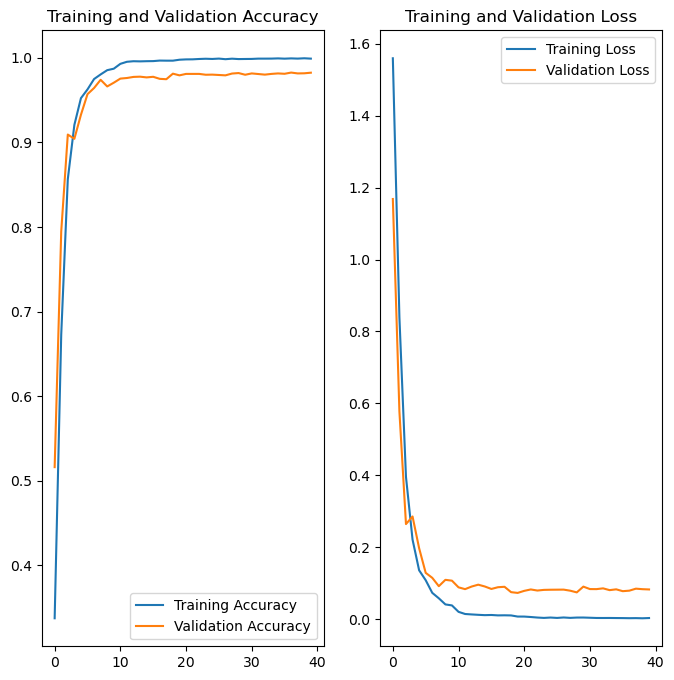

In [42]:
maxAcc = np.max(fitHistory.history['val_accuracy'])
print('Maximum test accuracy is at', np.round(maxAcc*100,2), '%.')
plotAccuracyLoss(fitHistory)
#-----------------------

In [43]:
printConfusionMatrix(model, val_ds)
earlyModelPath = saveSDOModel(model)

877/877 [==============================] - 13s 15ms/step
Confusion Matrix
[[1158    0    0    0    0    5]
 [   1 1138    0    0   10   18]
 [   0    6 1143    0    1   13]
 [   1    4    0 1185    1    0]
 [   0   11    0    0 1162    0]
 [   4   12    6   30    0 1107]]


Classification Report
                         precision    recall  f1-score   support

       Aedes albopictus       0.99      1.00      1.00      1163
           Aedes vexans       0.97      0.98      0.97      1167
     Anopheles sinensis       0.99      0.98      0.99      1163
          Culex pipiens       0.98      0.99      0.99      1191
Culex tritaeniorhynchus       0.99      0.99      0.99      1173
            Non vectors       0.97      0.96      0.96      1159

               accuracy                           0.98      7016
              macro avg       0.98      0.98      0.98      7016
           weighted avg       0.98      0.98      0.98      7016

Model is saved in ./models/Model_SDO_Park_2022-09-

In [44]:
#-----Run 6

In [45]:
tmpX = tempfile.TemporaryDirectory().name
RandomTrainValTest(mos_img_dir, tmpX, ratio = (0.8,0.2,0))
#-----------------------

Ratio = (0.8, 0.2, -0.0).
Found Aedes vexans
No. of files in Aedes vexans = 5901.
No. of files in "/tmp/tmp9e_8dz06/train/Aedes vexans/" should be around 4721.
No. of files in /tmp/tmp9e_8dz06/train/Aedes vexans/ = 4733.
No. of files in "/tmp/tmp9e_8dz06/test/Aedes vexans/" should be around 0.
No. of files in /tmp/tmp9e_8dz06/test/Aedes vexans/ = 0.
No. of files in "/tmp/tmp9e_8dz06/val/Aedes vexans/" should be around 1181.
No. of files in /tmp/tmp9e_8dz06/val/Aedes vexans/ = 1168.
Found Anopheles sinensis
No. of files in Anopheles sinensis = 5923.
No. of files in "/tmp/tmp9e_8dz06/train/Anopheles sinensis/" should be around 4739.
No. of files in /tmp/tmp9e_8dz06/train/Anopheles sinensis/ = 4749.
No. of files in "/tmp/tmp9e_8dz06/test/Anopheles sinensis/" should be around 0.
No. of files in /tmp/tmp9e_8dz06/test/Anopheles sinensis/ = 0.
No. of files in "/tmp/tmp9e_8dz06/val/Anopheles sinensis/" should be around 1185.
No. of files in /tmp/tmp9e_8dz06/val/Anopheles sinensis/ = 1174.
Foun

In [46]:
(train_ds, val_ds) = read_ds(tmpX)
(train_ds, val_ds) = preprocessDS(train_ds, val_ds)
#-----------------------

Found 28633 files belonging to 6 classes.
Found 7107 files belonging to 6 classes.


In [47]:
model = buildSDModel()
model = loadVGG16ImageNetWeightsSD(model)
model = compileModel(model)
fitHistory = fitModel(model, train_ds, val_ds, lr_adjust, early_stopping)
#-----------------------

Start fitting from 2022/09/26-22:22:18

Epoch 1: LearningRateScheduler setting learning rate to 1.9999999494757503e-05.
Epoch 1/40
3580/3580 [==============================] - 223s 60ms/step - loss: 1.4383 - accuracy: 0.3956 - val_loss: 0.8346 - val_accuracy: 0.6926 - lr: 2.0000e-05

Epoch 2: LearningRateScheduler setting learning rate to 1.9999999494757503e-05.
Epoch 2/40
3580/3580 [==============================] - 218s 61ms/step - loss: 0.6661 - accuracy: 0.7500 - val_loss: 0.4127 - val_accuracy: 0.8417 - lr: 2.0000e-05

Epoch 3: LearningRateScheduler setting learning rate to 1.9999999494757503e-05.
Epoch 3/40
3580/3580 [==============================] - 204s 57ms/step - loss: 0.3167 - accuracy: 0.8861 - val_loss: 0.3256 - val_accuracy: 0.8808 - lr: 2.0000e-05

Epoch 4: LearningRateScheduler setting learning rate to 1.9999999494757503e-05.
Epoch 4/40
3580/3580 [==============================] - 209s 58ms/step - loss: 0.1820 - accuracy: 0.9358 - val_loss: 0.2580 - val_accuracy: 0.901

Epoch 34/40
3580/3580 [==============================] - 203s 57ms/step - loss: 0.0019 - accuracy: 0.9994 - val_loss: 0.1025 - val_accuracy: 0.9755 - lr: 2.5000e-06

Epoch 35: LearningRateScheduler setting learning rate to 2.499999936844688e-06.
Epoch 35/40
3580/3580 [==============================] - 202s 56ms/step - loss: 0.0019 - accuracy: 0.9994 - val_loss: 0.1040 - val_accuracy: 0.9747 - lr: 2.5000e-06

Epoch 36: LearningRateScheduler setting learning rate to 2.499999936844688e-06.
Epoch 36/40
3580/3580 [==============================] - 202s 56ms/step - loss: 0.0015 - accuracy: 0.9996 - val_loss: 0.1110 - val_accuracy: 0.9744 - lr: 2.5000e-06

Epoch 37: LearningRateScheduler setting learning rate to 2.499999936844688e-06.
Epoch 37/40
3580/3580 [==============================] - 199s 56ms/step - loss: 0.0028 - accuracy: 0.9993 - val_loss: 0.1037 - val_accuracy: 0.9769 - lr: 2.5000e-06

Epoch 38: LearningRateScheduler setting learning rate to 2.499999936844688e-06.
Epoch 38/40
3580

Maximum test accuracy is at 97.69 %.


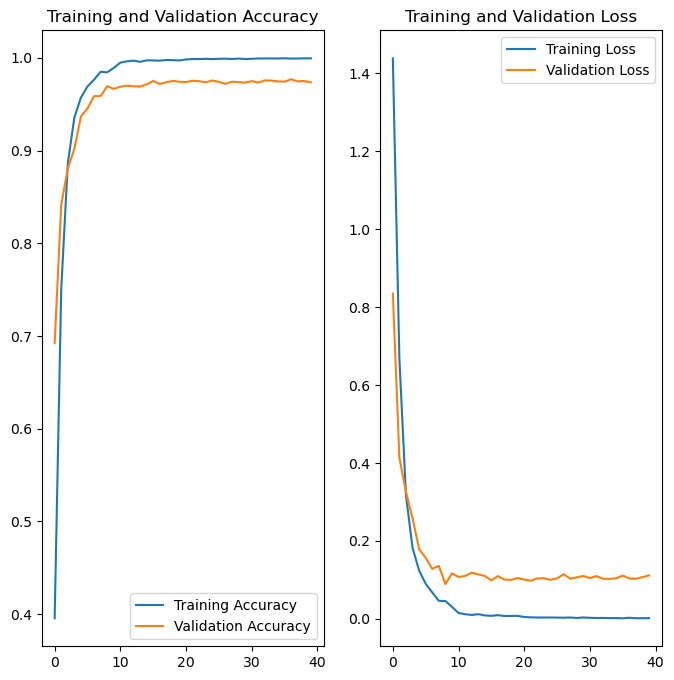

In [48]:
maxAcc = np.max(fitHistory.history['val_accuracy'])
print('Maximum test accuracy is at', np.round(maxAcc*100,2), '%.')
plotAccuracyLoss(fitHistory)
#-----------------------

In [49]:
printConfusionMatrix(model, val_ds)
earlyModelPath = saveSDOModel(model)

889/889 [==============================] - 14s 15ms/step
Confusion Matrix
[[1174    2    0    8    6    5]
 [   1 1113    1    5   28   20]
 [   0    7 1154    1    0   12]
 [   0    0    0 1189    0    0]
 [   0   26    1    0 1161    0]
 [   9   18    3   29    5 1129]]


Classification Report
                         precision    recall  f1-score   support

       Aedes albopictus       0.99      0.98      0.99      1195
           Aedes vexans       0.95      0.95      0.95      1168
     Anopheles sinensis       1.00      0.98      0.99      1174
          Culex pipiens       0.97      1.00      0.98      1189
Culex tritaeniorhynchus       0.97      0.98      0.97      1188
            Non vectors       0.97      0.95      0.96      1193

               accuracy                           0.97      7107
              macro avg       0.97      0.97      0.97      7107
           weighted avg       0.97      0.97      0.97      7107

Model is saved in ./models/Model_SDO_Park_2022-09-

In [50]:
#-----Run 7

In [51]:
tmpX = tempfile.TemporaryDirectory().name
RandomTrainValTest(mos_img_dir, tmpX, ratio = (0.8,0.2,0))
#-----------------------

Ratio = (0.8, 0.2, -0.0).
Found Aedes vexans
No. of files in Aedes vexans = 5901.
No. of files in "/tmp/tmp76okq_vw/train/Aedes vexans/" should be around 4721.
No. of files in /tmp/tmp76okq_vw/train/Aedes vexans/ = 4741.
No. of files in "/tmp/tmp76okq_vw/test/Aedes vexans/" should be around 0.
No. of files in /tmp/tmp76okq_vw/test/Aedes vexans/ = 0.
No. of files in "/tmp/tmp76okq_vw/val/Aedes vexans/" should be around 1181.
No. of files in /tmp/tmp76okq_vw/val/Aedes vexans/ = 1160.
Found Anopheles sinensis
No. of files in Anopheles sinensis = 5923.
No. of files in "/tmp/tmp76okq_vw/train/Anopheles sinensis/" should be around 4739.
No. of files in /tmp/tmp76okq_vw/train/Anopheles sinensis/ = 4748.
No. of files in "/tmp/tmp76okq_vw/test/Anopheles sinensis/" should be around 0.
No. of files in /tmp/tmp76okq_vw/test/Anopheles sinensis/ = 0.
No. of files in "/tmp/tmp76okq_vw/val/Anopheles sinensis/" should be around 1185.
No. of files in /tmp/tmp76okq_vw/val/Anopheles sinensis/ = 1175.
Foun

In [52]:
(train_ds, val_ds) = read_ds(tmpX)
(train_ds, val_ds) = preprocessDS(train_ds, val_ds)
#-----------------------

Found 28683 files belonging to 6 classes.
Found 7057 files belonging to 6 classes.


In [53]:
model = buildSDModel()
model = loadVGG16ImageNetWeightsSD(model)
model = compileModel(model)
fitHistory = fitModel(model, train_ds, val_ds, lr_adjust, early_stopping)
#-----------------------

Start fitting from 2022/09/27-00:40:00

Epoch 1: LearningRateScheduler setting learning rate to 1.9999999494757503e-05.
Epoch 1/40
3586/3586 [==============================] - 211s 57ms/step - loss: 1.6078 - accuracy: 0.3260 - val_loss: 1.1520 - val_accuracy: 0.5397 - lr: 2.0000e-05

Epoch 2: LearningRateScheduler setting learning rate to 1.9999999494757503e-05.
Epoch 2/40
3586/3586 [==============================] - 206s 57ms/step - loss: 0.9137 - accuracy: 0.6419 - val_loss: 0.6079 - val_accuracy: 0.7804 - lr: 2.0000e-05

Epoch 3: LearningRateScheduler setting learning rate to 1.9999999494757503e-05.
Epoch 3/40
3586/3586 [==============================] - 206s 58ms/step - loss: 0.4584 - accuracy: 0.8305 - val_loss: 0.3433 - val_accuracy: 0.8756 - lr: 2.0000e-05

Epoch 4: LearningRateScheduler setting learning rate to 1.9999999494757503e-05.
Epoch 4/40
3586/3586 [==============================] - 205s 57ms/step - loss: 0.2479 - accuracy: 0.9118 - val_loss: 0.2093 - val_accuracy: 0.928

Epoch 34/40
3586/3586 [==============================] - 203s 56ms/step - loss: 0.0026 - accuracy: 0.9993 - val_loss: 0.1265 - val_accuracy: 0.9763 - lr: 2.5000e-06

Epoch 35: LearningRateScheduler setting learning rate to 2.499999936844688e-06.
Epoch 35/40
3586/3586 [==============================] - 207s 58ms/step - loss: 0.0034 - accuracy: 0.9988 - val_loss: 0.1261 - val_accuracy: 0.9759 - lr: 2.5000e-06

Epoch 36: LearningRateScheduler setting learning rate to 2.499999936844688e-06.
Epoch 36/40
3586/3586 [==============================] - 208s 58ms/step - loss: 0.0030 - accuracy: 0.9990 - val_loss: 0.1260 - val_accuracy: 0.9763 - lr: 2.5000e-06

Epoch 37: LearningRateScheduler setting learning rate to 2.499999936844688e-06.
Epoch 37/40
3586/3586 [==============================] - 202s 56ms/step - loss: 0.0031 - accuracy: 0.9991 - val_loss: 0.1195 - val_accuracy: 0.9768 - lr: 2.5000e-06

Epoch 38: LearningRateScheduler setting learning rate to 2.499999936844688e-06.
Epoch 38/40
3586

Maximum test accuracy is at 97.79 %.


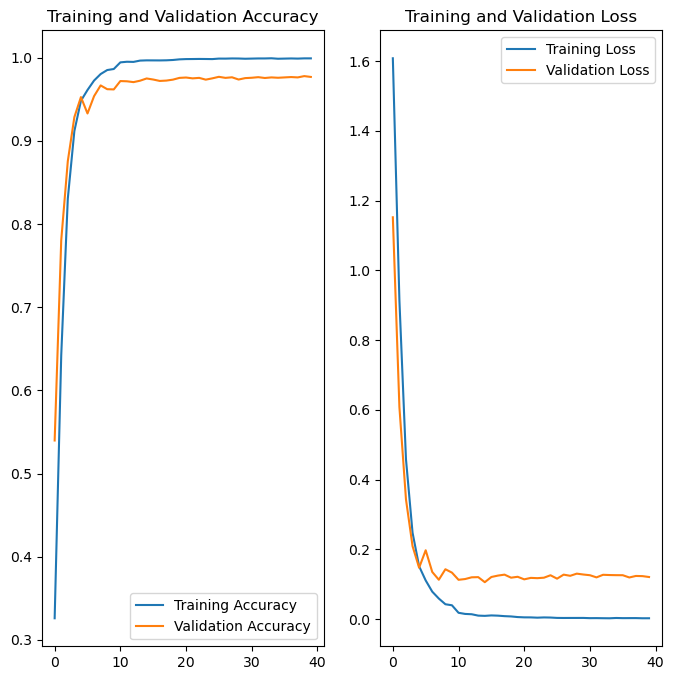

In [54]:
maxAcc = np.max(fitHistory.history['val_accuracy'])
print('Maximum test accuracy is at', np.round(maxAcc*100,2), '%.')
plotAccuracyLoss(fitHistory)
#-----------------------

In [55]:
printConfusionMatrix(model, val_ds)
earlyModelPath = saveSDOModel(model)

883/883 [==============================] - 13s 15ms/step
Confusion Matrix
[[1155   10    3    2    2    3]
 [   1 1114    3    4   27   11]
 [   1    0 1146    1    0   27]
 [   1    2    0 1190    0    1]
 [   0   29    2    0 1151    0]
 [   4    9    3   13    4 1138]]


Classification Report
                         precision    recall  f1-score   support

       Aedes albopictus       0.99      0.98      0.99      1175
           Aedes vexans       0.96      0.96      0.96      1160
     Anopheles sinensis       0.99      0.98      0.98      1175
          Culex pipiens       0.98      1.00      0.99      1194
Culex tritaeniorhynchus       0.97      0.97      0.97      1182
            Non vectors       0.96      0.97      0.97      1171

               accuracy                           0.98      7057
              macro avg       0.98      0.98      0.98      7057
           weighted avg       0.98      0.98      0.98      7057

Model is saved in ./models/Model_SDO_Park_2022-09-

In [56]:
#-----Run 8

In [57]:
tmpX = tempfile.TemporaryDirectory().name
RandomTrainValTest(mos_img_dir, tmpX, ratio = (0.8,0.2,0))
#-----------------------

Ratio = (0.8, 0.2, -0.0).
Found Aedes vexans
No. of files in Aedes vexans = 5901.
No. of files in "/tmp/tmpct6bltd9/train/Aedes vexans/" should be around 4721.
No. of files in /tmp/tmpct6bltd9/train/Aedes vexans/ = 4728.
No. of files in "/tmp/tmpct6bltd9/test/Aedes vexans/" should be around 0.
No. of files in /tmp/tmpct6bltd9/test/Aedes vexans/ = 0.
No. of files in "/tmp/tmpct6bltd9/val/Aedes vexans/" should be around 1181.
No. of files in /tmp/tmpct6bltd9/val/Aedes vexans/ = 1173.
Found Anopheles sinensis
No. of files in Anopheles sinensis = 5923.
No. of files in "/tmp/tmpct6bltd9/train/Anopheles sinensis/" should be around 4739.
No. of files in /tmp/tmpct6bltd9/train/Anopheles sinensis/ = 4742.
No. of files in "/tmp/tmpct6bltd9/test/Anopheles sinensis/" should be around 0.
No. of files in /tmp/tmpct6bltd9/test/Anopheles sinensis/ = 0.
No. of files in "/tmp/tmpct6bltd9/val/Anopheles sinensis/" should be around 1185.
No. of files in /tmp/tmpct6bltd9/val/Anopheles sinensis/ = 1181.
Foun

In [58]:
(train_ds, val_ds) = read_ds(tmpX)
(train_ds, val_ds) = preprocessDS(train_ds, val_ds)
#-----------------------

Found 28713 files belonging to 6 classes.
Found 7027 files belonging to 6 classes.


In [59]:
model = buildSDModel()
model = loadVGG16ImageNetWeightsSD(model)
model = compileModel(model)
fitHistory = fitModel(model, train_ds, val_ds, lr_adjust, early_stopping)
#-----------------------

Start fitting from 2022/09/27-02:55:54

Epoch 1: LearningRateScheduler setting learning rate to 1.9999999494757503e-05.
Epoch 1/40
3590/3590 [==============================] - 213s 58ms/step - loss: 1.5360 - accuracy: 0.3485 - val_loss: 1.0383 - val_accuracy: 0.5596 - lr: 2.0000e-05

Epoch 2: LearningRateScheduler setting learning rate to 1.9999999494757503e-05.
Epoch 2/40
3590/3590 [==============================] - 208s 58ms/step - loss: 0.8555 - accuracy: 0.6595 - val_loss: 0.7005 - val_accuracy: 0.7292 - lr: 2.0000e-05

Epoch 3: LearningRateScheduler setting learning rate to 1.9999999494757503e-05.
Epoch 3/40
3590/3590 [==============================] - 210s 59ms/step - loss: 0.4457 - accuracy: 0.8362 - val_loss: 0.3545 - val_accuracy: 0.8709 - lr: 2.0000e-05

Epoch 4: LearningRateScheduler setting learning rate to 1.9999999494757503e-05.
Epoch 4/40
3590/3590 [==============================] - 203s 56ms/step - loss: 0.2440 - accuracy: 0.9124 - val_loss: 0.2509 - val_accuracy: 0.907

Epoch 34/40
3590/3590 [==============================] - 204s 57ms/step - loss: 0.0026 - accuracy: 0.9993 - val_loss: 0.1001 - val_accuracy: 0.9778 - lr: 2.5000e-06

Epoch 35: LearningRateScheduler setting learning rate to 2.499999936844688e-06.
Epoch 35/40
3590/3590 [==============================] - 204s 57ms/step - loss: 0.0035 - accuracy: 0.9990 - val_loss: 0.1044 - val_accuracy: 0.9782 - lr: 2.5000e-06

Epoch 36: LearningRateScheduler setting learning rate to 2.499999936844688e-06.
Epoch 36/40
3590/3590 [==============================] - 201s 56ms/step - loss: 0.0026 - accuracy: 0.9990 - val_loss: 0.1033 - val_accuracy: 0.9779 - lr: 2.5000e-06

Epoch 37: LearningRateScheduler setting learning rate to 2.499999936844688e-06.
Epoch 37/40
3590/3590 [==============================] - 203s 57ms/step - loss: 0.0021 - accuracy: 0.9994 - val_loss: 0.1013 - val_accuracy: 0.9794 - lr: 2.5000e-06

Epoch 38: LearningRateScheduler setting learning rate to 2.499999936844688e-06.
Epoch 38/40
3590

Maximum test accuracy is at 98.06 %.


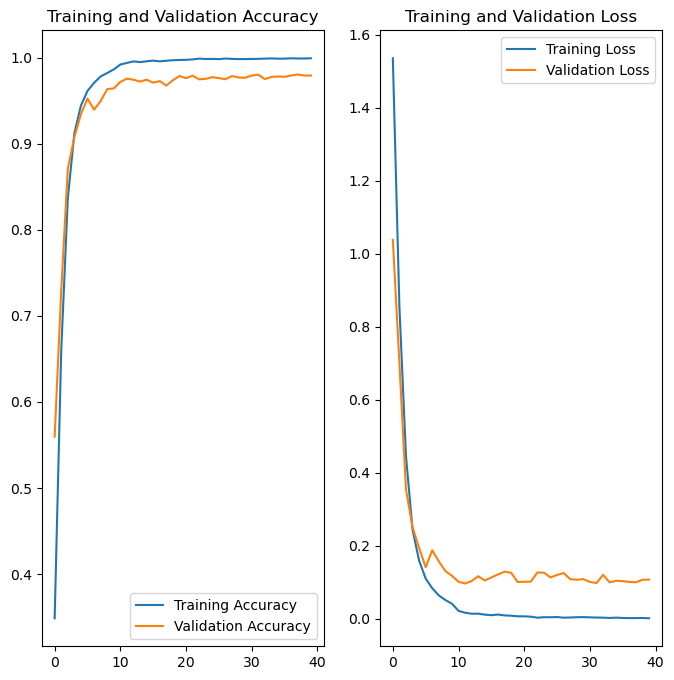

In [60]:
maxAcc = np.max(fitHistory.history['val_accuracy'])
print('Maximum test accuracy is at', np.round(maxAcc*100,2), '%.')
plotAccuracyLoss(fitHistory)
#-----------------------

In [61]:
printConfusionMatrix(model, val_ds)
earlyModelPath = saveSDOModel(model)

879/879 [==============================] - 13s 15ms/step
Confusion Matrix
[[1133   27    0    1    0   10]
 [   0 1146    0    0   23    4]
 [   0    4 1162    0    1   14]
 [   0    0    1 1186    0    1]
 [   1   29    1    1 1142    0]
 [   5    9    3    9    1 1113]]


Classification Report
                         precision    recall  f1-score   support

       Aedes albopictus       0.99      0.97      0.98      1171
           Aedes vexans       0.94      0.98      0.96      1173
     Anopheles sinensis       1.00      0.98      0.99      1181
          Culex pipiens       0.99      1.00      0.99      1188
Culex tritaeniorhynchus       0.98      0.97      0.98      1174
            Non vectors       0.97      0.98      0.98      1140

               accuracy                           0.98      7027
              macro avg       0.98      0.98      0.98      7027
           weighted avg       0.98      0.98      0.98      7027

Model is saved in ./models/Model_SDO_Park_2022-09-

In [62]:
#-----Run 9

In [63]:
tmpX = tempfile.TemporaryDirectory().name
RandomTrainValTest(mos_img_dir, tmpX, ratio = (0.8,0.2,0))
#-----------------------

Ratio = (0.8, 0.2, -0.0).
Found Aedes vexans
No. of files in Aedes vexans = 5901.
No. of files in "/tmp/tmpq5sbmxmd/train/Aedes vexans/" should be around 4721.
No. of files in /tmp/tmpq5sbmxmd/train/Aedes vexans/ = 4735.
No. of files in "/tmp/tmpq5sbmxmd/test/Aedes vexans/" should be around 0.
No. of files in /tmp/tmpq5sbmxmd/test/Aedes vexans/ = 0.
No. of files in "/tmp/tmpq5sbmxmd/val/Aedes vexans/" should be around 1181.
No. of files in /tmp/tmpq5sbmxmd/val/Aedes vexans/ = 1166.
Found Anopheles sinensis
No. of files in Anopheles sinensis = 5923.
No. of files in "/tmp/tmpq5sbmxmd/train/Anopheles sinensis/" should be around 4739.
No. of files in /tmp/tmpq5sbmxmd/train/Anopheles sinensis/ = 4739.
No. of files in "/tmp/tmpq5sbmxmd/test/Anopheles sinensis/" should be around 0.
No. of files in /tmp/tmpq5sbmxmd/test/Anopheles sinensis/ = 0.
No. of files in "/tmp/tmpq5sbmxmd/val/Anopheles sinensis/" should be around 1185.
No. of files in /tmp/tmpq5sbmxmd/val/Anopheles sinensis/ = 1184.
Foun

In [64]:
(train_ds, val_ds) = read_ds(tmpX)
(train_ds, val_ds) = preprocessDS(train_ds, val_ds)
#-----------------------

Found 28689 files belonging to 6 classes.
Found 7051 files belonging to 6 classes.


In [65]:
model = buildSDModel()
model = loadVGG16ImageNetWeightsSD(model)
model = compileModel(model)
fitHistory = fitModel(model, train_ds, val_ds, lr_adjust, early_stopping)
#-----------------------

Start fitting from 2022/09/27-05:12:59

Epoch 1: LearningRateScheduler setting learning rate to 1.9999999494757503e-05.
Epoch 1/40
3587/3587 [==============================] - 217s 59ms/step - loss: 1.5436 - accuracy: 0.3336 - val_loss: 1.0966 - val_accuracy: 0.5592 - lr: 2.0000e-05

Epoch 2: LearningRateScheduler setting learning rate to 1.9999999494757503e-05.
Epoch 2/40
3587/3587 [==============================] - 206s 57ms/step - loss: 0.8538 - accuracy: 0.6698 - val_loss: 0.5321 - val_accuracy: 0.8081 - lr: 2.0000e-05

Epoch 3: LearningRateScheduler setting learning rate to 1.9999999494757503e-05.
Epoch 3/40
3587/3587 [==============================] - 207s 58ms/step - loss: 0.4250 - accuracy: 0.8452 - val_loss: 0.2923 - val_accuracy: 0.8939 - lr: 2.0000e-05

Epoch 4: LearningRateScheduler setting learning rate to 1.9999999494757503e-05.
Epoch 4/40
3587/3587 [==============================] - 208s 58ms/step - loss: 0.2332 - accuracy: 0.9159 - val_loss: 0.1934 - val_accuracy: 0.930

Epoch 34/40
3587/3587 [==============================] - 204s 57ms/step - loss: 0.0024 - accuracy: 0.9992 - val_loss: 0.0970 - val_accuracy: 0.9770 - lr: 2.5000e-06

Epoch 35: LearningRateScheduler setting learning rate to 2.499999936844688e-06.
Epoch 35/40
3587/3587 [==============================] - 204s 57ms/step - loss: 0.0021 - accuracy: 0.9993 - val_loss: 0.1029 - val_accuracy: 0.9746 - lr: 2.5000e-06

Epoch 36: LearningRateScheduler setting learning rate to 2.499999936844688e-06.
Epoch 36/40
3587/3587 [==============================] - 203s 57ms/step - loss: 0.0024 - accuracy: 0.9992 - val_loss: 0.1038 - val_accuracy: 0.9753 - lr: 2.5000e-06

Epoch 37: LearningRateScheduler setting learning rate to 2.499999936844688e-06.
Epoch 37/40
3587/3587 [==============================] - 202s 56ms/step - loss: 0.0021 - accuracy: 0.9994 - val_loss: 0.1142 - val_accuracy: 0.9736 - lr: 2.5000e-06

Epoch 38: LearningRateScheduler setting learning rate to 2.499999936844688e-06.
Epoch 38/40
3587

Maximum test accuracy is at 97.8 %.


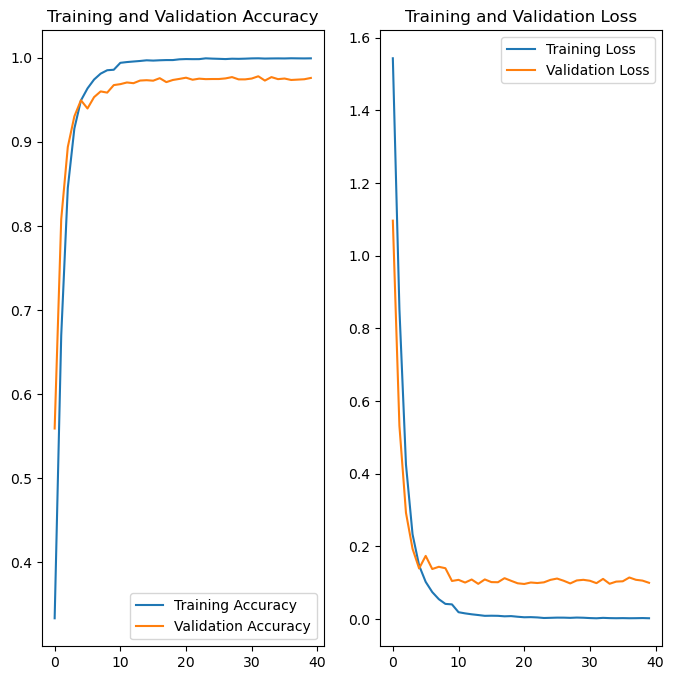

In [66]:
maxAcc = np.max(fitHistory.history['val_accuracy'])
print('Maximum test accuracy is at', np.round(maxAcc*100,2), '%.')
plotAccuracyLoss(fitHistory)
#-----------------------

In [67]:
printConfusionMatrix(model, val_ds)
earlyModelPath = saveSDOModel(model)

882/882 [==============================] - 13s 15ms/step
Confusion Matrix
[[1172    6    0    0    1    5]
 [   0 1114    6   11   14   21]
 [   0   14 1149    0    1   20]
 [   0    1    0 1188    1    4]
 [   0   25    1    0 1134    0]
 [   3   10    2   18    5 1125]]


Classification Report
                         precision    recall  f1-score   support

       Aedes albopictus       1.00      0.99      0.99      1184
           Aedes vexans       0.95      0.96      0.95      1166
     Anopheles sinensis       0.99      0.97      0.98      1184
          Culex pipiens       0.98      0.99      0.99      1194
Culex tritaeniorhynchus       0.98      0.98      0.98      1160
            Non vectors       0.96      0.97      0.96      1163

               accuracy                           0.98      7051
              macro avg       0.98      0.98      0.98      7051
           weighted avg       0.98      0.98      0.98      7051

Model is saved in ./models/Model_SDO_Park_2022-09-

In [68]:
#-----Run 10

In [69]:
tmpX = tempfile.TemporaryDirectory().name
RandomTrainValTest(mos_img_dir, tmpX, ratio = (0.8,0.2,0))

#-----------------------

Ratio = (0.8, 0.2, -0.0).
Found Aedes vexans
No. of files in Aedes vexans = 5901.
No. of files in "/tmp/tmpf1lrn15_/train/Aedes vexans/" should be around 4721.
No. of files in /tmp/tmpf1lrn15_/train/Aedes vexans/ = 4740.
No. of files in "/tmp/tmpf1lrn15_/test/Aedes vexans/" should be around 0.
No. of files in /tmp/tmpf1lrn15_/test/Aedes vexans/ = 0.
No. of files in "/tmp/tmpf1lrn15_/val/Aedes vexans/" should be around 1181.
No. of files in /tmp/tmpf1lrn15_/val/Aedes vexans/ = 1161.
Found Anopheles sinensis
No. of files in Anopheles sinensis = 5923.
No. of files in "/tmp/tmpf1lrn15_/train/Anopheles sinensis/" should be around 4739.
No. of files in /tmp/tmpf1lrn15_/train/Anopheles sinensis/ = 4739.
No. of files in "/tmp/tmpf1lrn15_/test/Anopheles sinensis/" should be around 0.
No. of files in /tmp/tmpf1lrn15_/test/Anopheles sinensis/ = 0.
No. of files in "/tmp/tmpf1lrn15_/val/Anopheles sinensis/" should be around 1185.
No. of files in /tmp/tmpf1lrn15_/val/Anopheles sinensis/ = 1184.
Foun

In [70]:
(train_ds, val_ds) = read_ds(tmpX)
(train_ds, val_ds) = preprocessDS(train_ds, val_ds)
#-----------------------

Found 28646 files belonging to 6 classes.
Found 7094 files belonging to 6 classes.


In [71]:
model = buildSDModel()
model = loadVGG16ImageNetWeightsSD(model)
model = compileModel(model)
fitHistory = fitModel(model, train_ds, val_ds, lr_adjust, early_stopping)
#-----------------------

Start fitting from 2022/09/27-07:29:49

Epoch 1: LearningRateScheduler setting learning rate to 1.9999999494757503e-05.
Epoch 1/40
3581/3581 [==============================] - 212s 57ms/step - loss: 1.6923 - accuracy: 0.2552 - val_loss: 1.3868 - val_accuracy: 0.4447 - lr: 2.0000e-05

Epoch 2: LearningRateScheduler setting learning rate to 1.9999999494757503e-05.
Epoch 2/40
3581/3581 [==============================] - 208s 58ms/step - loss: 1.0412 - accuracy: 0.5864 - val_loss: 0.7186 - val_accuracy: 0.7081 - lr: 2.0000e-05

Epoch 3: LearningRateScheduler setting learning rate to 1.9999999494757503e-05.
Epoch 3/40
3581/3581 [==============================] - 208s 58ms/step - loss: 0.5095 - accuracy: 0.8118 - val_loss: 0.3666 - val_accuracy: 0.8610 - lr: 2.0000e-05

Epoch 4: LearningRateScheduler setting learning rate to 1.9999999494757503e-05.
Epoch 4/40
3581/3581 [==============================] - 201s 56ms/step - loss: 0.2625 - accuracy: 0.9047 - val_loss: 0.2424 - val_accuracy: 0.921

Epoch 34/40
3581/3581 [==============================] - 204s 57ms/step - loss: 0.0018 - accuracy: 0.9995 - val_loss: 0.1933 - val_accuracy: 0.9622 - lr: 2.5000e-06

Epoch 35: LearningRateScheduler setting learning rate to 2.499999936844688e-06.
Epoch 35/40
3581/3581 [==============================] - 202s 56ms/step - loss: 0.0019 - accuracy: 0.9994 - val_loss: 0.1895 - val_accuracy: 0.9618 - lr: 2.5000e-06

Epoch 36: LearningRateScheduler setting learning rate to 2.499999936844688e-06.
Epoch 36/40
3581/3581 [==============================] - 200s 56ms/step - loss: 0.0024 - accuracy: 0.9993 - val_loss: 0.2049 - val_accuracy: 0.9618 - lr: 2.5000e-06

Epoch 37: LearningRateScheduler setting learning rate to 2.499999936844688e-06.
Epoch 37/40
3581/3581 [==============================] - 204s 57ms/step - loss: 0.0039 - accuracy: 0.9988 - val_loss: 0.2116 - val_accuracy: 0.9602 - lr: 2.5000e-06

Epoch 38: LearningRateScheduler setting learning rate to 2.499999936844688e-06.
Epoch 38/40
3581

Maximum test accuracy is at 96.35 %.


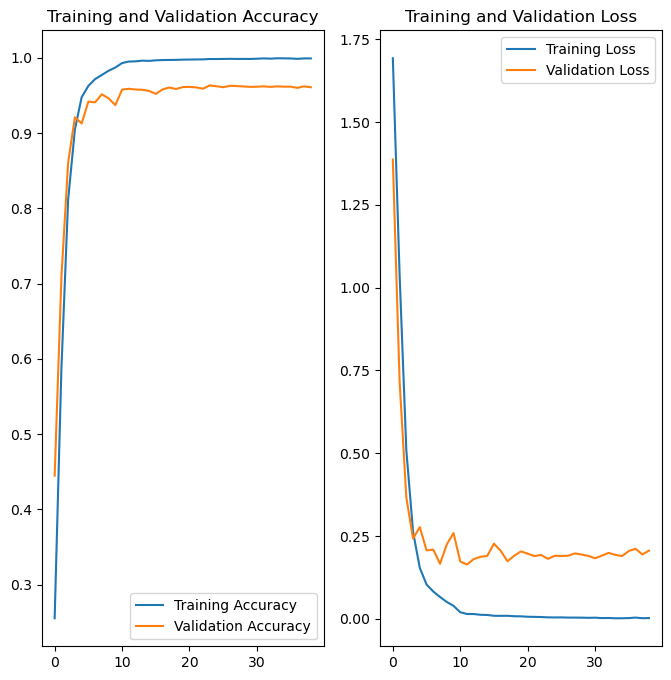

In [72]:
maxAcc = np.max(fitHistory.history['val_accuracy'])
print('Maximum test accuracy is at', np.round(maxAcc*100,2), '%.')
plotAccuracyLoss(fitHistory)
#-----------------------

In [73]:
printConfusionMatrix(model, val_ds)
earlyModelPath = saveSDOModel(model)

887/887 [==============================] - 14s 15ms/step
Confusion Matrix
[[1185    2    0    1    1   10]
 [   0 1085    1    6   53   16]
 [   3   55 1097    0    3   26]
 [   0    0    0 1175    0    9]
 [   0   38    0    0 1128    0]
 [  11   15    0    7    2 1165]]


Classification Report
                         precision    recall  f1-score   support

       Aedes albopictus       0.99      0.99      0.99      1199
           Aedes vexans       0.91      0.93      0.92      1161
     Anopheles sinensis       1.00      0.93      0.96      1184
          Culex pipiens       0.99      0.99      0.99      1184
Culex tritaeniorhynchus       0.95      0.97      0.96      1166
            Non vectors       0.95      0.97      0.96      1200

               accuracy                           0.96      7094
              macro avg       0.96      0.96      0.96      7094
           weighted avg       0.96      0.96      0.96      7094

Model is saved in ./models/Model_SDO_Park_2022-09-